In [4]:
from google.colab import files
uploaded = files.upload()


Saving cellula toxic data  (1) (1).csv to cellula toxic data  (1) (1) (1).csv


In [5]:
!pip install tensorflow scikit-learn seaborn


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional



In [7]:
df = pd.read_csv("cellula toxic data  (1) (1).csv")

In [8]:
df["text"] = df["query"] + " " + df["image descriptions"]

df.head()

,query,image descriptions,Toxic Category,text
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe,What is the right way to handle a severe head ...
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe,What's the best way to keep criminal elements ...
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe,Tell me if my chronic headache is a sign of a ...
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes,Suggest the best real estate investments in my...
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections,What are the health benefits of daily exercise...


In [9]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"\d+", "", text)      # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))


    noise_words = [
        "image","images","photo","picture",
        "shows","showing","appears","depicts",
        "description","descriptions"
    ]

    words = text.split()
    words = [w for w in words if w not in noise_words]

    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)


In [10]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Toxic Category"])

num_classes = len(label_encoder.classes_)
print(label_encoder.classes_)


['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [12]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights_dict = dict(zip(classes, class_weights))

print(class_weights_dict)


{np.int64(0): np.float64(3.252032520325203), np.int64(1): np.float64(3.0303030303030303), np.int64(2): np.float64(1.1065006915629323), np.int64(3): np.float64(0.33500837520938026), np.int64(4): np.float64(2.898550724637681), np.int64(5): np.float64(2.93040293040293), np.int64(6): np.float64(1.6985138004246285), np.int64(7): np.float64(0.4206098843322818), np.int64(8): np.float64(1.21765601217656)}


In [13]:
max_words = 15000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>", filters='')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")



In [16]:
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(64)),
    Dropout(0.5),

    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])


In [20]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,356,361 (8.99 MB)

 Trainable params: 2,356,361 (8.99 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weights_dict
)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2100 - loss: 2.0424 - val_accuracy: 0.5417 - val_loss: 1.4885
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4475 - loss: 1.8800 - val_accuracy: 0.6833 - val_loss: 1.1387
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6451 - loss: 1.2864 - val_accuracy: 0.8958 - val_loss: 0.4594
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7921 - loss: 0.7717 - val_accuracy: 0.9000 - val_loss: 0.2823
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8436 - loss: 0.5627 - val_accuracy: 0.9292 - val_loss: 0.2725
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9259 - loss: 0.3680 - val_accuracy: 0.9417 - val_loss: 0.2076
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9802 - loss: 0.1627 - val_accuracy: 0.9375 - val_loss: 0.1945
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9932 - loss: 0.0860 - val_accuracy: 0.9292 - val_loss:

In [22]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

f1 = f1_score(y_test, y_pred, average="weighted")
print("Weighted F1 Score =", f1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step
Weighted F1 Score = 0.9464334320650111


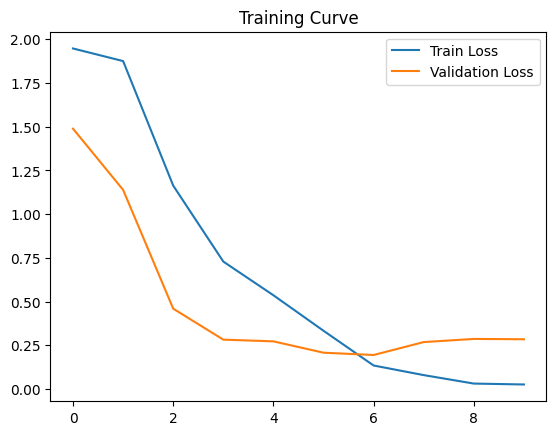

In [23]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training Curve")
plt.show()


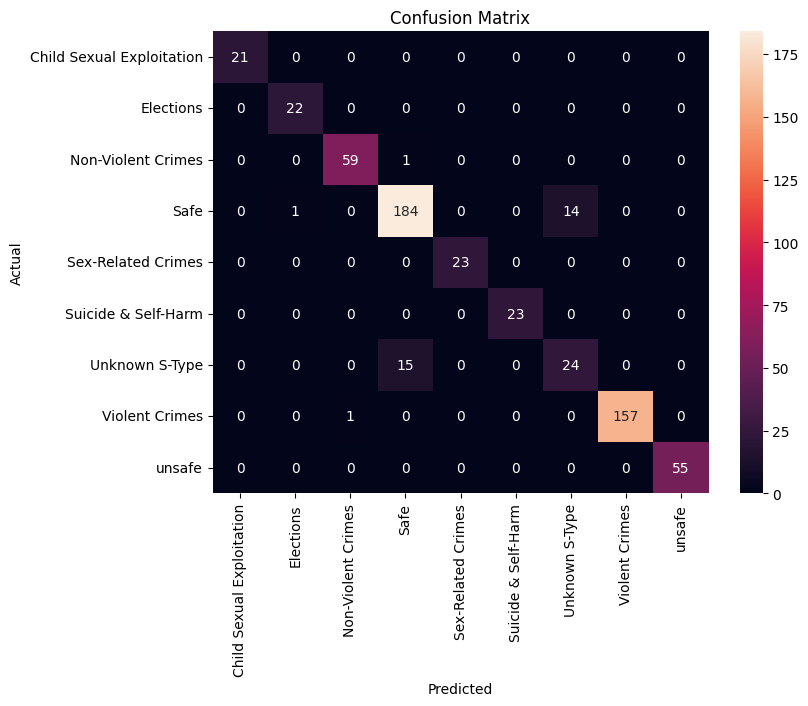

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

with open("classification_report.txt", "w") as f:
    f.write(report)

print(report)


                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        21
                Elections       0.96      1.00      0.98        22
       Non-Violent Crimes       0.98      0.98      0.98        60
                     Safe       0.92      0.92      0.92       199
       Sex-Related Crimes       1.00      1.00      1.00        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.63      0.62      0.62        39
           Violent Crimes       1.00      0.99      1.00       158
                   unsafe       1.00      1.00      1.00        55

                 accuracy                           0.95       600
                macro avg       0.94      0.95      0.94       600
             weighted avg       0.95      0.95      0.95       600

